In [2]:
import pandas as pd
import psycopg2
import os
from dotenv import load_dotenv
import numpy as np

import pandas as pd
from geopy.distance import geodesic
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import plotly.express as px
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

In [3]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)


query_string = "SELECT * FROM  eda.king_county_house_details d JOIN eda.king_county_house_sales s  ON s.house_id = d.id"
df = pd.read_sql(query_string, conn)
df = df[df['zipcode'].astype(str).str.startswith('981')]


/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37384/1898604628.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query_string, conn)


In [4]:
df.dtypes

id                 int64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
date              object
price            float64
house_id           int64
id                 int64
dtype: object

In [5]:
model = ols('grade ~ C(zipcode)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                 sum_sq      df         F  PR(>F)
C(zipcode)  1553.793716    28.0  64.90266     0.0
Residual    7647.238268  8944.0       NaN     NaN


                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     64.90
Date:                Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:30:21   Log-Likelihood:                -12015.
No. Observations:                8973   AIC:                         2.409e+04
Df Residuals:                    8944   BIC:                         2.429e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.2981    

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37384/1844174327.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


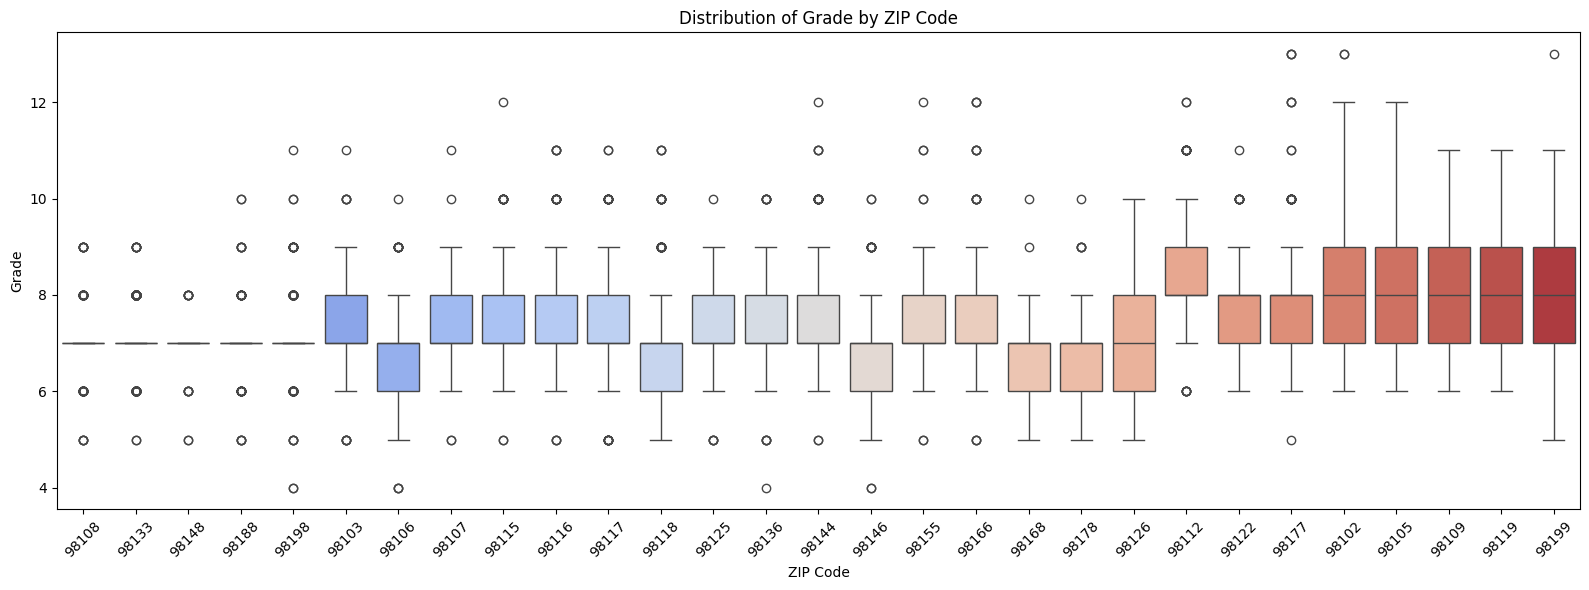

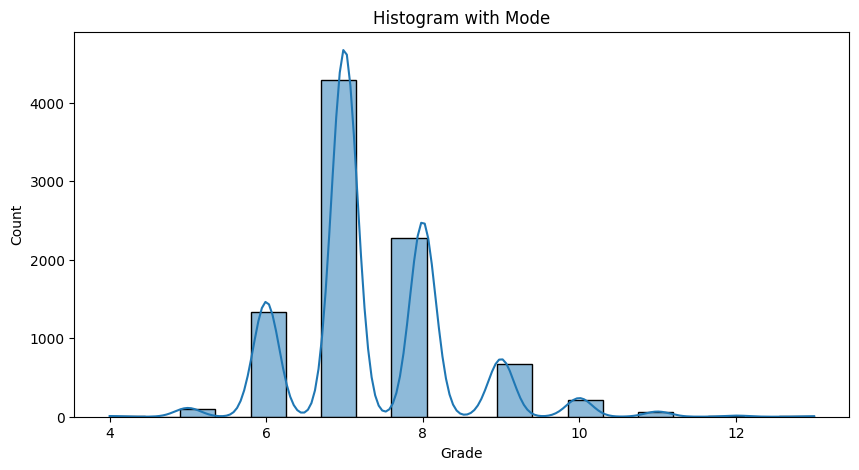

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37384/1844174327.py:53: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


In [ ]:
model = smf.ols('grade ~ C(zipcode)', data=df).fit()
print(model.summary())
grouped = df.groupby('zipcode')['grade'].agg(
    median='median',
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
).sort_values(['median', 'iqr'])

order = grouped.index
plt.figure(figsize=(16, 6))


sns.boxplot(
    x='zipcode',
    y='grade',
    data=df,  
    palette='coolwarm',
    order=order
)

plt.title('Distribution of Grade by ZIP Code')
plt.xlabel('ZIP Code')
plt.ylabel('Grade')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,5))
sns.histplot(df['grade'], bins=20, kde=True)
plt.title('Histogram with Mode')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

zip_stats = (
    df.groupby('zipcode')
    .agg(
        avg_grade=('grade', 'mean'),
        lat=('lat', 'first'),
        lng=('long', 'first')
    )
    .reset_index()
)
zip_stats['cluster'] = zip_stats['avg_grade'].apply(
    lambda x: 'High-Grade >=8' if x >= 8 else 'Low-Grade'
)
fig = px.scatter_mapbox(
    zip_stats,
    lat="lat",
    lon="lng",
    color="cluster",
    size="avg_grade",  
    hover_name="zipcode",
    hover_data={"avg_grade": True},
    mapbox_style="carto-positron",
    zoom=10,
    title="High-Grade vs. Low-Grade ZIP Clusters"
)

fig.show()



In [7]:
zip_stats.sort_values('cluster')[['zipcode', 'cluster']]

,zipcode,cluster
0,98102,High-Grade >=8
12,98119,High-Grade >=8
7,98112,High-Grade >=8
6,98109,High-Grade >=8
28,98199,High-Grade >=8
5,98108,Low-Grade
26,98188,Low-Grade
25,98178,Low-Grade
24,98177,Low-Grade
23,98168,Low-Grade
